In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Gaussian Pyramid
The first is the Gaussian Pyramid. This is made by taking an image, and repeatedly filtering it with a Gaussian filter, then downsampling it. The filtering is important as it avoids aliasing, which occurs when a signal is sampled below its Nyquist frequency.

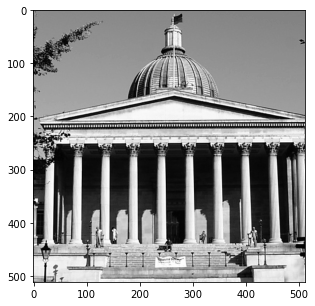

In [3]:
def show_grayscale_im(image):
  plt.figure(figsize = (5, 5))
  plt.imshow(image, cmap = "gray", vmin = 0, vmax = 1)

portico_image = cv2.imread("portico.jpg").astype(float) / 255.0
portico_image = portico_image[..., 0]
show_grayscale_im(portico_image)

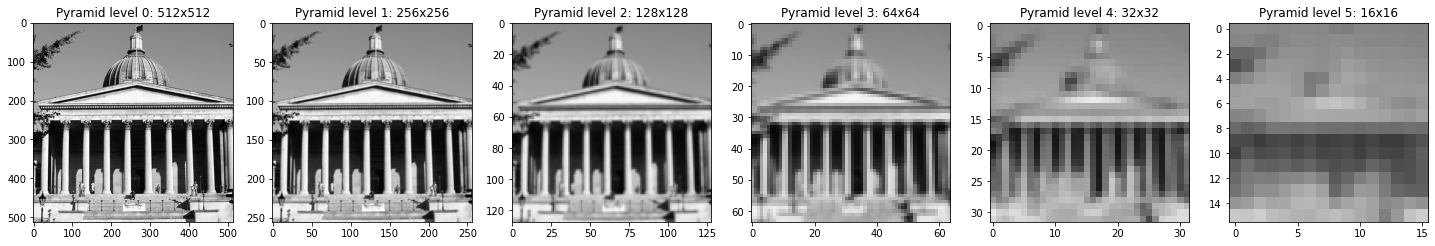

In [5]:
# Gaussian Pyramid
num_levels = 5

gaussian_pyramid = [portico_image]
for i in range(num_levels):
  gaussian_pyramid.append(cv2.pyrDown(gaussian_pyramid[-1]))

plt.figure(figsize = (25, 10))
for i in range(len(gaussian_pyramid)):
  plt.subplot(1, len(gaussian_pyramid), i + 1)
  plt.title("Pyramid level %d: %dx%d" % (i, gaussian_pyramid[i].shape[0], gaussian_pyramid[i].shape[1]))
  plt.imshow(gaussian_pyramid[i], cmap = "gray", vmin = 0, vmax = 1)

The Laplacian pyramid is strongly related to the Gaussian pyramid. Each level is the difference between two levels of the Gaussian pyramid. The last level (the smallest one) is identical to the Gaussian pyramid. You'll probably notice that we can't subtract the levels straight away because they are of different sizes. To get each pair of levels to the same size, we upsample the smaller image and then blur it.

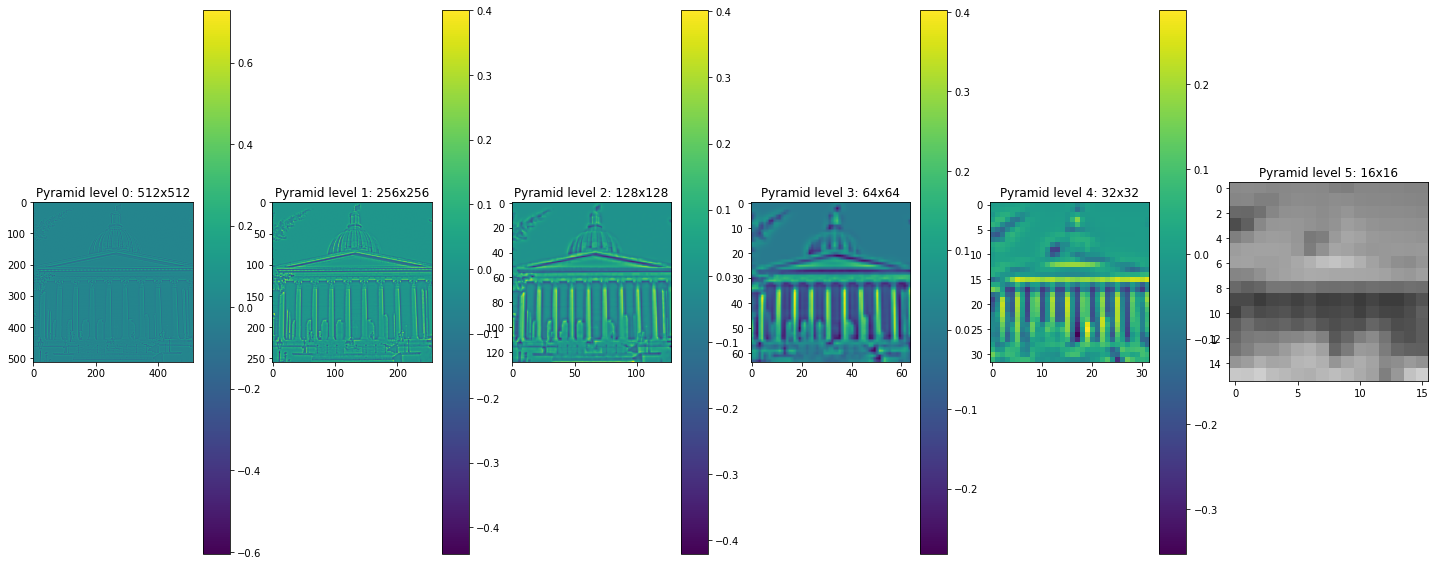

In [6]:
# Laplacian Pyramid
laplacian_pyramid = [gaussian_pyramid[-1]]
for i in reversed(range(len(gaussian_pyramid) - 1)):
  laplacian_pyramid.insert(0, gaussian_pyramid[i] - cv2.pyrUp(gaussian_pyramid[i + 1]))

plt.figure(figsize=(25, 10))
for i in range(len(laplacian_pyramid)):
  plt.subplot(1, len(laplacian_pyramid), i + 1)
  plt.title("Pyramid level %d: %dx%d" % (i, laplacian_pyramid[i].shape[0], laplacian_pyramid[i].shape[1]))
  if i < len(laplacian_pyramid) - 1:
    plt.imshow(laplacian_pyramid[i])
    plt.colorbar()
  else:
    plt.imshow(laplacian_pyramid[i], cmap = "gray", vmin = 0, vmax = 1)

The Laplacian pyramid isn't always positive-valued, except for the lowest-resolution level. This is because each level is a difference between two images. This pyramid is useful because each level captures the high-frequency information that can't be expressed in the level below it. We can reconstruct an image from its laplacian pyramid by adding the layers.

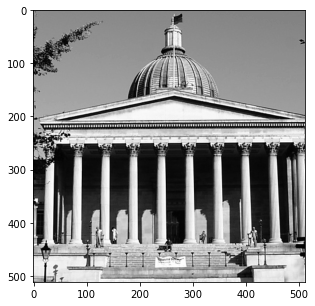

In [7]:
reconstructed_image = laplacian_pyramid[-1]
for layer in reversed(laplacian_pyramid[:-1]):
  reconstructed_image = cv2.pyrUp(reconstructed_image) + layer

plt.figure(figsize = (5, 5))
plt.imshow(reconstructed_image, cmap = "gray", vmin = 0, vmax = 1)

Laplacian and Gaussian pyramids have a lot of useful applications, but one fun application for Laplacian pyramids is image blending. Two images can be blended smoothly by just combining each of their Laplacian pyramid levels, and then reconstructing from the resulting pyramid.

The original paper by Burt and Adelson introducing this blending process is here: http://persci.mit.edu/pub_pdfs/spline83.pdf

In [8]:
def make_gaussian_pyramid(image, num_levels):
  gaussian_pyramid = [image]
  for i in range(num_levels - 1):
    gaussian_pyramid.append(cv2.pyrDown(gaussian_pyramid[-1]))
  return gaussian_pyramid

def make_laplacian_pyramid(gaussian_pyramid):
  laplacian_pyramid = [gaussian_pyramid[-1]]
  for i in reversed(range(len(gaussian_pyramid) - 1)):
    laplacian_pyramid.insert(0, gaussian_pyramid[i] - cv2.pyrUp(gaussian_pyramid[i + 1]))
  return laplacian_pyramid

def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
  reconstructed_image = laplacian_pyramid[-1]
  for layer in reversed(laplacian_pyramid[:-1]):
    reconstructed_image = cv2.pyrUp(reconstructed_image) + layer
  return reconstructed_image

def display_laplacian_pyramid(laplacian_pyramid):
  plt.figure(figsize = (25, 10))
  for i in range(len(laplacian_pyramid)):
    plt.subplot(1, len(laplacian_pyramid), i + 1)
    plt.title("Pyramid level %d: %dx%d" % (i, laplacian_pyramid[i].shape[0], laplacian_pyramid[i].shape[1]))
    if i < len(laplacian_pyramid) - 1:
      plt.imshow(laplacian_pyramid[i])
      plt.colorbar()
    else:
      plt.imshow(laplacian_pyramid[i], cmap = "gray", vmin = 0, vmax = 1)

figure 7 in the paper: http://persci.mit.edu/pub_pdfs/spline83.pdf

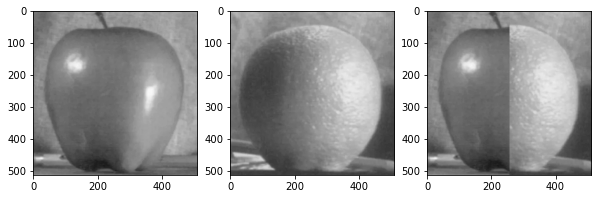

In [9]:
apple_image = cv2.imread("apple.webp")[..., 0].astype(float) / 255.0
orange_image = cv2.imread("orange.webp")[..., 0].astype(float) / 255.0
apple_left = apple_image[:, :apple_image.shape[1] // 2]
orange_right = orange_image[:, orange_image.shape[1] // 2:]
combined = np.concatenate([apple_left, orange_right], 1)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(apple_image, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 3, 2)
plt.imshow(orange_image, cmap = "gray", vmin = 0, vmax = 1)
plt.subplot(1, 3, 3)
plt.imshow(combined, cmap = "gray", vmin = 0, vmax = 1)

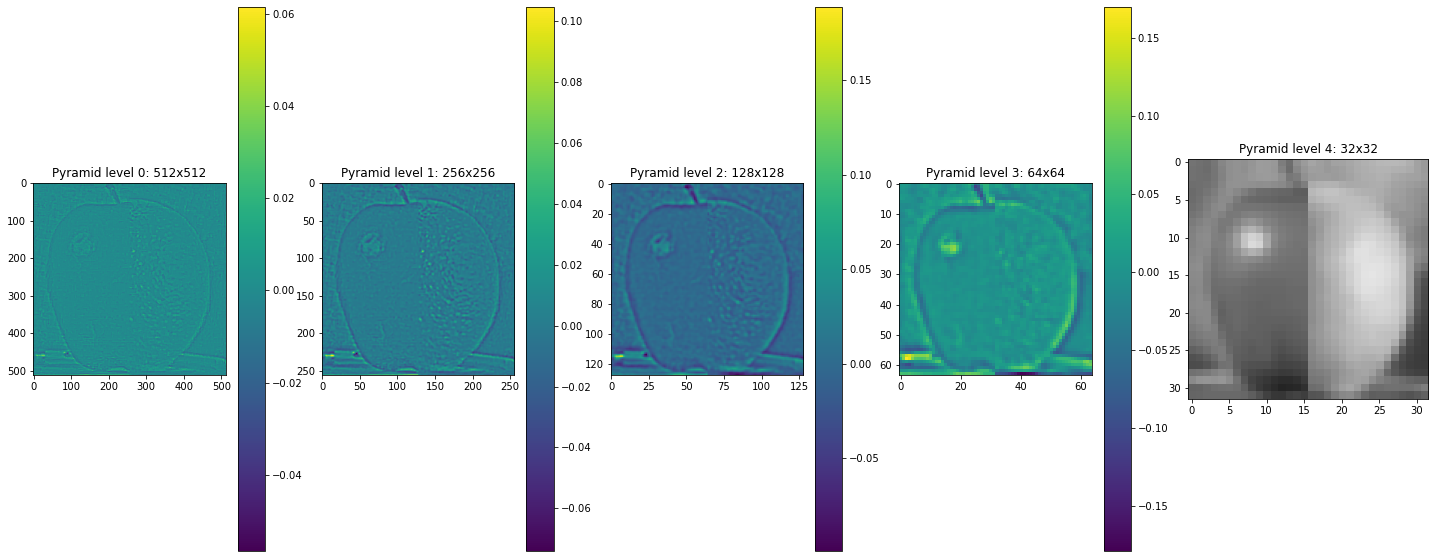

In [10]:
# Laplacian Pyramid Blending
apple_gauss = make_gaussian_pyramid(apple_image, 5)
apple_laplace = make_laplacian_pyramid(apple_gauss)
orange_gauss = make_gaussian_pyramid(orange_image, 5)
orange_laplace = make_laplacian_pyramid(orange_gauss)

combined_laplace = []
for i in range(len(apple_laplace)):
  apple_left = apple_laplace[i][:, :apple_laplace[i].shape[1] // 2]
  orange_right = orange_laplace[i][:, orange_laplace[i].shape[1] // 2:]
  combined = np.concatenate([apple_left, orange_right], 1)
  combined_laplace.append(combined)

display_laplacian_pyramid(combined_laplace)

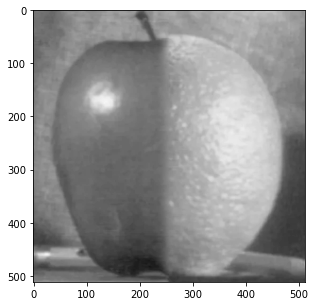

In [12]:
combined_image = reconstruct_from_laplacian_pyramid(combined_laplace)

plt.figure(figsize=(5, 5))
plt.imshow(combined_image, cmap = "gray", vmin = 0, vmax = 1)